In [1]:
import numpy as np

In [2]:
!git clone https://github.com/HansBambel/multidim_conv.git

Cloning into 'multidim_conv'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 59 (delta 10), reused 12 (delta 3), pack-reused 34
Unpacking objects: 100% (59/59), 145.58 MiB | 14.00 MiB/s, done.


In [3]:
import pickle
with open('./multidim_conv/data/Wind_data_NL/dataset.pkl', 'rb') as f:
    data = pickle.load(f)

with open('./multidim_conv/data/Wind_data_NL/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

In [4]:
# history_length is timestep of the historical window size
# predict_length is the prediction horizon
def build_data(data, x_len, y_len, gap=1):
    x = []
    y = []
    length = data.shape[0]
    for end_idx in range(x_len + y_len + gap, length):
        xtime = data[end_idx-y_len-x_len-gap:end_idx-y_len-gap]
        ytime = data[end_idx-y_len-gap:end_idx-gap]
        x.append(xtime)
        y.append(ytime)
    x = np.stack(x)
    y = np.stack(y)
    return x, y


"""Build data and train test split"""
def make_ready_data(data, train=True, gap=1):
    x_len = 10  # 10 historical time steps
    y_len = 1  # next step
    
    x, y = build_data(data[:, :, 0], x_len, y_len, gap)
    x, y = x.reshape(x.shape[0], 10, 7), y.reshape(y.shape[0], 7)
    
    if train:
        xtrain = x[:60000]
        ytrain = y[:60000]
        xval = x[60000:]
        yval = y[60000:]
    
        return xtrain, xval, ytrain, yval
    else:
        return x, y

train_data = data['train']
test_data = data['test']

xtrain, xval, ytrain, yval = make_ready_data(train_data, gap=1)
xtest, ytest = make_ready_data(test_data, train=False, gap=1)
xtrain.shape, xval.shape, ytrain.shape, yval.shape,xtest.shape, ytest.shape

((60000, 10, 7),
 (10116, 10, 7),
 (60000, 7),
 (10116, 7),
 (10860, 10, 7),
 (10860, 7))

In [5]:
import torch

def build_dl(xtrain, xval, xtest, ytrain, yval, ytest):
    """convert arrays to tensors"""
    batch_size = 32
    xtrain = torch.Tensor(xtrain).to(device)
    ytrain = torch.Tensor(ytrain).to(device)
    xval = torch.Tensor(xval).to(device)
    yval = torch.Tensor(yval).to(device)
    xtest = torch.Tensor(xtest).to(device)
    ytest = torch.Tensor(ytest).to(device)
    train_data = torch.utils.data.TensorDataset(xtrain, ytrain)
    train_iter = torch.utils.data.DataLoader(train_data, batch_size)
    val_data = torch.utils.data.TensorDataset(xval, yval)
    val_iter = torch.utils.data.DataLoader(val_data, batch_size)
    test_data = torch.utils.data.TensorDataset(xtest, ytest)
    test_iter = torch.utils.data.DataLoader(test_data, batch_size)
    
    return train_iter, val_iter, test_iter

device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_iter, val_iter, test_iter = build_dl(xtrain, xval, xtest, ytrain, yval, ytest)

In [6]:
from torch import nn
from torch.autograd import Variable

class LSTM(nn.Module):
    def __init__(self, output_size, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = 10
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=self.hidden_size,
                            num_layers=num_layers, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        h0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size))
        c0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size))

        lstm_out, (hn, cn) = self.lstm(x, (h0, c0))
        #hn = hn.view(-1, self.hidden_size*2)
        out = lstm_out[:, -1, :]
        out = self.linear(out)
    
        return out

In [7]:
"""Validation loop"""
def validate(model):
    model.eval()
    losses = []
    with torch.no_grad():
        for x, y in val_iter:
            outputs = model(x)
            loss = loss_fn(outputs.cpu(), y.cpu())
            losses.append(loss)
    mean_loss = np.mean(losses)
    return mean_loss


"""Train loop"""
def run_train(model):
    NUM_EPOCHS = 50
    for epoch in range(NUM_EPOCHS):
        losses = []
    
        for x, y in train_iter:
            outputs = model(x)
            loss = loss_fn(outputs, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        
        train_loss = np.mean(losses)
        val_loss = validate(model) 
    
        if epoch % 5 == 0:
            print('Epoch: ', epoch+1, ', Train Loss: ', train_loss, ', Val Loss: ', val_loss)
                  
    return model

input_size = output_size = 7
hidden_size = 16
num_layers = 1
lstm_model = LSTM(output_size, input_size, hidden_size, num_layers)
lstm_model = lstm_model.to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)
lstm_model = run_train(lstm_model)

Epoch:  1 , Train Loss:  0.0022838132216905552 , Val Loss:  0.0019396623
Epoch:  6 , Train Loss:  0.001658577032542477 , Val Loss:  0.0017420982
Epoch:  11 , Train Loss:  0.0016166517629909018 , Val Loss:  0.0016746041
Epoch:  16 , Train Loss:  0.001600246074081709 , Val Loss:  0.0016487055
Epoch:  21 , Train Loss:  0.0015906414069856206 , Val Loss:  0.0016423836
Epoch:  26 , Train Loss:  0.0015837718922334413 , Val Loss:  0.0016403409
Epoch:  31 , Train Loss:  0.0015785235965624451 , Val Loss:  0.0016374933
Epoch:  36 , Train Loss:  0.0015745595601076882 , Val Loss:  0.0016369376
Epoch:  41 , Train Loss:  0.0015716316491365433 , Val Loss:  0.0016373867
Epoch:  46 , Train Loss:  0.0015685511095759768 , Val Loss:  0.0016391601


In [8]:
"""Test data predictions"""
def run_test(model):
    model.eval()
    y_preds = list()
    y_true = list()

    max_wind = scaler['feature_max_train'][0]
    min_wind = scaler['feature_min_train'][0]

    with torch.no_grad():
        for x, y in test_iter:
            y = y.cpu().numpy().reshape(-1)
            y_pred = model(x).view(len(y), -1).cpu().numpy().reshape(-1)
            y = y * max_wind + min_wind
            y_pred = y_pred * max_wind + min_wind
            y_preds.extend(list(y_pred))
            y_true.extend(list(y))
        
    y_preds = np.array(y_preds)
    y_true = np.array(y_true)
    y_true = y_true.reshape(int(y_true.shape[0]/7), 7)
    y_preds = y_preds.reshape(int(y_preds.shape[0]/7), 7)
    
    return y_true, y_preds

y_true, y_preds = run_test(lstm_model)

RMSE:  9.9157715
MAE:  7.5149746


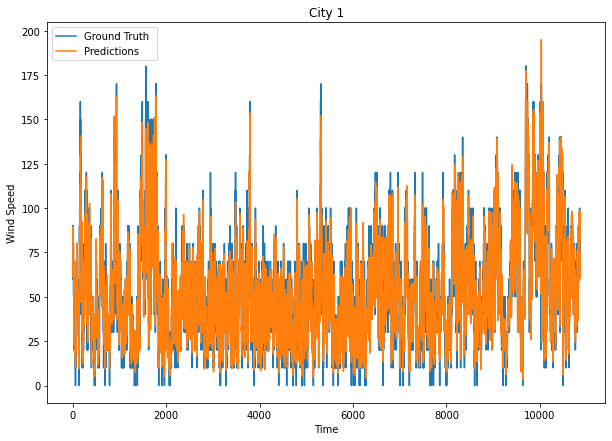

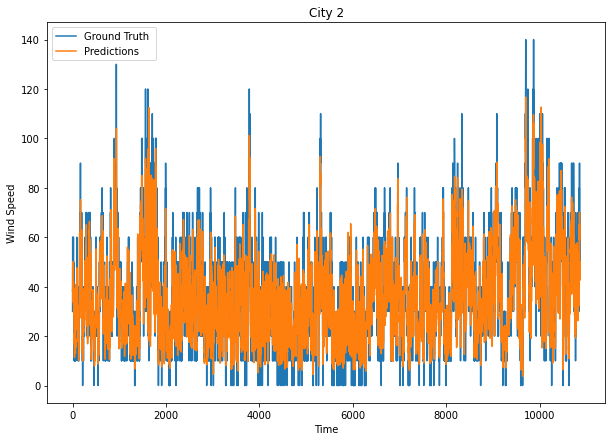

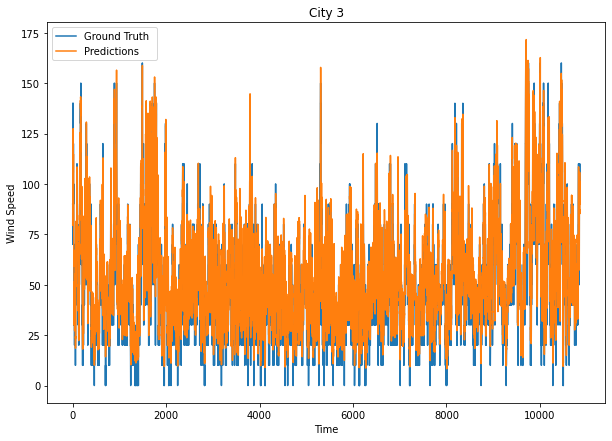

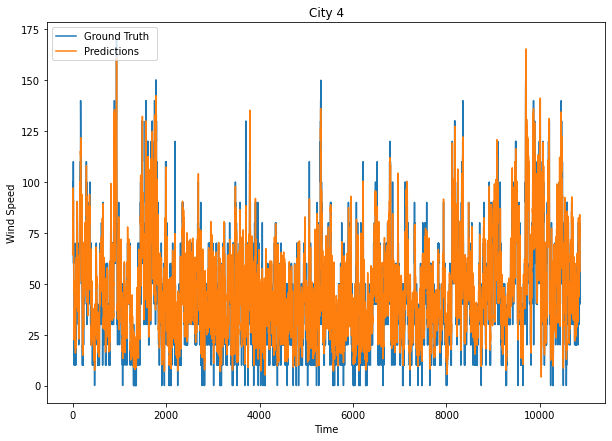

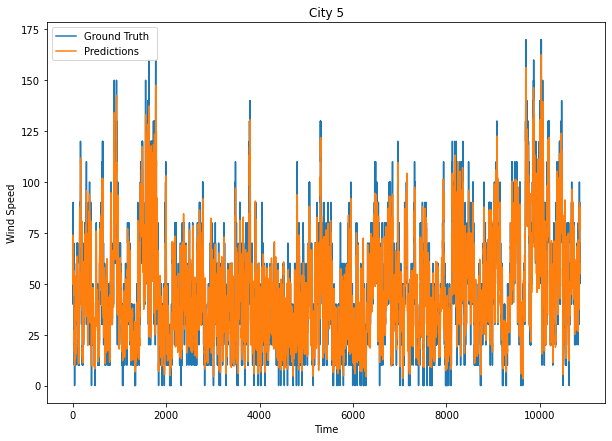

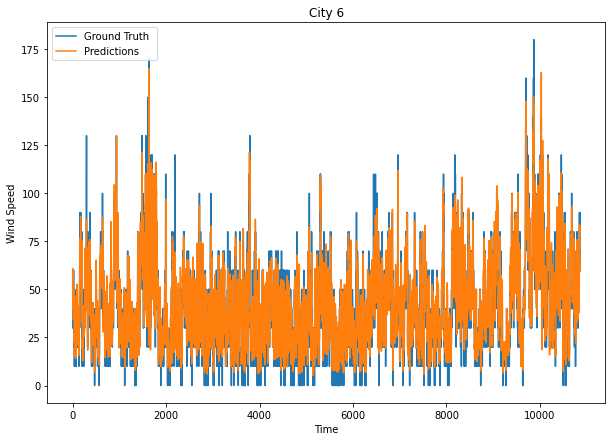

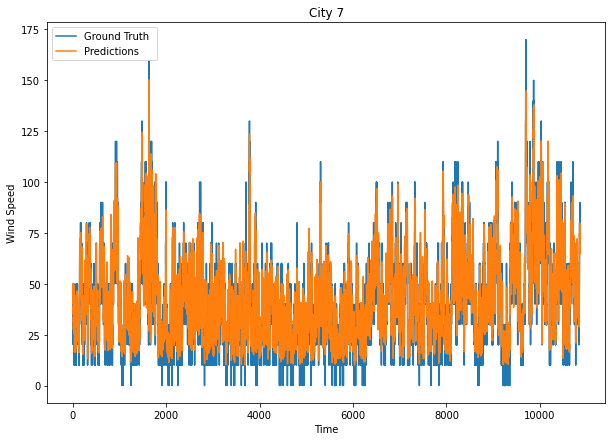

In [9]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

def results(y_true, y_preds, plots=True):
    """Visualization of windspeed predictions vs ground truth and
    Overall evaluation the predictions of the test data"""
    
    print('RMSE: ', np.sqrt(mean_squared_error(y_true.flatten(), y_preds.flatten())))
    print('MAE: ', mean_absolute_error(y_true.flatten(), y_preds.flatten()))

    if plots:
        for i in range(7):
            plt.figure(figsize=(10,7))
            plt.plot(range(len(y_true[:, i])), y_true[:, i], label='Ground Truth ')
            plt.plot(range(len(y_preds[:, i])), y_preds[:, i], label='Predictions')
            plt.title('City '+str(i+1))
            plt.xlabel('Time')
            plt.ylabel('Wind Speed')
            plt.legend(loc="upper left")
            plt.show()
        
results(y_true, y_preds, plots=True)

# 5 time steps Gap

In [10]:
xtrain, xval, ytrain, yval = make_ready_data(train_data, gap=5)
xtest, ytest = make_ready_data(test_data, train=False, gap=5)
train_iter, val_iter, test_iter = build_dl(xtrain, xval, xtest, ytrain, yval, ytest)

lstm_model = LSTM(output_size, input_size, hidden_size, num_layers)
lstm_model = lstm_model.to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)
lstm_model = run_train(lstm_model)

y_true, y_preds = run_test(lstm_model)
print('Test Data:')
results(y_true, y_preds, plots=False)

Epoch:  1 , Train Loss:  0.0021990211189724506 , Val Loss:  0.0020137585
Epoch:  6 , Train Loss:  0.0016501138252516588 , Val Loss:  0.0017811267
Epoch:  11 , Train Loss:  0.0016183705103894074 , Val Loss:  0.0017380714
Epoch:  16 , Train Loss:  0.001603641255820791 , Val Loss:  0.0017182227
Epoch:  21 , Train Loss:  0.0015936252670983473 , Val Loss:  0.0017046037
Epoch:  26 , Train Loss:  0.0015871764929344257 , Val Loss:  0.0017060615
Epoch:  31 , Train Loss:  0.001582099477170656 , Val Loss:  0.0017041692
Epoch:  36 , Train Loss:  0.0015778366788290442 , Val Loss:  0.0016985448
Epoch:  41 , Train Loss:  0.0015742999406841893 , Val Loss:  0.0016910707
Epoch:  46 , Train Loss:  0.001571254783247908 , Val Loss:  0.0016838488
Test Data:
RMSE:  10.033386
MAE:  7.610664


# 10 time steps Gap

In [11]:
xtrain, xval, ytrain, yval = make_ready_data(train_data, gap=10)
xtest, ytest = make_ready_data(test_data, train=False, gap=10)
train_iter, val_iter, test_iter = build_dl(xtrain, xval, xtest, ytrain, yval, ytest)

lstm_model = LSTM(output_size, input_size, hidden_size, num_layers)
lstm_model = lstm_model.to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)
lstm_model = run_train(lstm_model)

y_true, y_preds = run_test(lstm_model)

print('Test Data:')
results(y_true, y_preds, plots=False)

Epoch:  1 , Train Loss:  0.0022209935458066565 , Val Loss:  0.0021029862
Epoch:  6 , Train Loss:  0.001657848598745962 , Val Loss:  0.0017882823
Epoch:  11 , Train Loss:  0.001618473582000782 , Val Loss:  0.001705034
Epoch:  16 , Train Loss:  0.0015998636346310378 , Val Loss:  0.0016757791
Epoch:  21 , Train Loss:  0.001589495576887081 , Val Loss:  0.0016628443
Epoch:  26 , Train Loss:  0.0015827047351437311 , Val Loss:  0.0016578771
Epoch:  31 , Train Loss:  0.001577642943772177 , Val Loss:  0.0016530865
Epoch:  36 , Train Loss:  0.001573657995617638 , Val Loss:  0.0016511815
Epoch:  41 , Train Loss:  0.001570523255287359 , Val Loss:  0.0016496693
Epoch:  46 , Train Loss:  0.001567742362897843 , Val Loss:  0.0016484698
Test Data:
RMSE:  9.93352
MAE:  7.516474


# 50 time steps Gap

In [12]:
xtrain, xval, ytrain, yval = make_ready_data(train_data, gap=50)
xtest, ytest = make_ready_data(test_data, train=False, gap=50)
train_iter, val_iter, test_iter = build_dl(xtrain, xval, xtest, ytrain, yval, ytest)

lstm_model = LSTM(output_size, input_size, hidden_size, num_layers)
lstm_model = lstm_model.to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)
lstm_model = run_train(lstm_model)

y_true, y_preds = run_test(lstm_model)

print('Test Data:')
results(y_true, y_preds, plots=False)

Epoch:  1 , Train Loss:  0.0021910875120510656 , Val Loss:  0.0021498897
Epoch:  6 , Train Loss:  0.0016530304267381628 , Val Loss:  0.0016961034
Epoch:  11 , Train Loss:  0.0016161149685271084 , Val Loss:  0.0016589845
Epoch:  16 , Train Loss:  0.001600174948417892 , Val Loss:  0.0016495262
Epoch:  21 , Train Loss:  0.0015909935222628215 , Val Loss:  0.0016429452
Epoch:  26 , Train Loss:  0.0015843786704043546 , Val Loss:  0.0016380291
Epoch:  31 , Train Loss:  0.0015794435631483793 , Val Loss:  0.0016365108
Epoch:  36 , Train Loss:  0.0015754326306593916 , Val Loss:  0.0016350307
Epoch:  41 , Train Loss:  0.001572299329781284 , Val Loss:  0.0016334157
Epoch:  46 , Train Loss:  0.0015702641646688183 , Val Loss:  0.0016331634
Test Data:
RMSE:  9.865738
MAE:  7.469475


## References:
- Dataset from "Trebing, Kevin and Mehrkanoon, Siamak, 2020, Wind speed prediction using multidimensional convolutional neural networks"